In [1]:
from dataloaders.colmap_scripts.read_write_dense import read_array
import matplotlib.pyplot as plt
import numpy as np

In [15]:
#path to depth map
depth_map_path = '/home/bharathsk/datasets/drop/colmap/drop_2/dense/stereo/depth_maps/frame_001.jpg.geometric.bin'
# depth_map_path = '/home/bharathsk/datasets/drop/colmap/drop_2/dense/stereo/depth_maps/frame_001.jpg.photometric.bin'

In [16]:
#load depth map
depth_map = read_array(depth_map_path)

In [17]:
print(depth_map.shape)
print(depth_map.dtype)
print(depth_map.min(), depth_map.max())

(1080, 1920)
float32
0.0 150.77429


In [18]:
#filter depth
min_depth_percentile = 5
max_depth_percentile = 95
min_depth, max_depth = np.percentile(
        depth_map, [min_depth_percentile, max_depth_percentile]
    )
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth

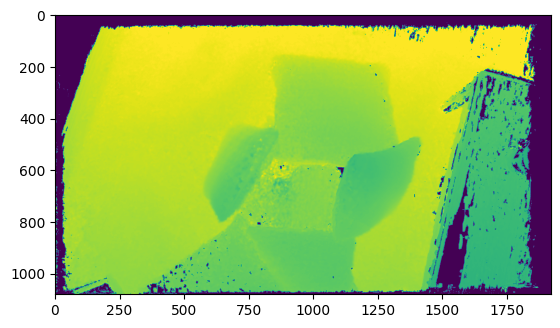

In [19]:
#plot depth map
plt.imshow(depth_map)

In [14]:
from densify_data import get_matcher
import cv2 as cv2
import os
import sys
sys.path.append('/home/bharathsk/projects/RoMa')
from roma import roma_outdoor

loftr_matcher = get_matcher()
roma_model = roma_outdoor(device='cuda', coarse_res=560, upsample_res=(864, 1152))

H, W = roma_model.get_output_resolution()

Initialize LoFTR_outdoor_ds


/home/bharathsk/anaconda3/envs/nerf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bharathsk/anaconda3/envs/nerf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 1152)


In [26]:
def compute_epe_loftr(root):
    #paths to images and gt disparity
    imgr_path = root + '/im2.png'
    imgl_path = root + '/im6.png'
    disp_path = root + '/disp2.png'
    
    if not os.path.exists(imgr_path) or not os.path.exists(imgl_path) or not os.path.exists(disp_path):
        print('Some files are missing')
        return None
    

    #load disparity
    disp = cv2.imread(disp_path, cv2.IMREAD_GRAYSCALE)
    disp = disp.astype(np.float32)/4.0

    #compute matches
    matches, _, _, _ = loftr_matcher(imgr_path, imgl_path)
    
    #filter matches
    ptsr = np.round(matches[:,0:2])
    ptsl = np.round(matches[:,2:4])

    #apply epipolar constraint
    mask = ptsr[:,1] == ptsl[:,1]

    ptsr_filt = ptsr[mask,:]
    ptsl_filt = ptsl[mask,:]
    matches_filt = matches[mask,:]
    
    #compute predicted disparity
    disp_pred = matches_filt[:,0] - matches_filt[:,2]
    
    #compute gt disparity
    disp_gt = disp[ptsr_filt[:,1].astype(int), ptsr_filt[:,0].astype(int)]
    
    #filter invalid disparity
    mask = disp_gt > 0
    disp_pred = disp_pred[mask]
    disp_gt = disp_gt[mask]
    
    epe = np.abs(disp_gt - disp_pred)
    epe_avg = np.mean(epe)
    
    print(epe.shape)
    
    return epe_avg    

In [21]:
def compute_epe_roma(root):
    #paths to images and gt disparity
    imgr_path = root + '/im2.ppm'
    imgl_path = root + '/im6.ppm'
    disp_path = root + '/disp2.pgm'
    
    if not os.path.exists(imgr_path) or not os.path.exists(imgl_path) or not os.path.exists(disp_path):
        print('Some files are missing')
        return None
    

    #load disparity
    disp = cv2.imread(disp_path, cv2.IMREAD_GRAYSCALE)

    #compute matches
    matches, _, _, _ = matcher(imgr_path, imgl_path)
    
    #filter matches
    ptsr = np.round(matches[:,0:2])
    ptsl = np.round(matches[:,2:4])

    #apply epipolar constraint
    mask = ptsr[:,1] == ptsl[:,1]

    ptsr_filt = ptsr[mask,:]
    ptsl_filt = ptsl[mask,:]
    matches_filt = matches[mask,:]
    
    #compute predicted disparity
    disp_pred = matches_filt[:,0] - matches_filt[:,2]
    
    #compute gt disparity
    disp_gt = disp[ptsr_filt[:,1].astype(int), ptsr_filt[:,0].astype(int)]
    
    #filter invalid disparity
    mask = disp_gt > 0
    disp_pred = disp_pred[mask]
    disp_gt = disp_gt[mask]
    
    epe = np.abs(disp_gt - disp_pred)
    epe_avg = np.mean(epe)
    
    print(epe.shape)
    
    return epe_avg

In [28]:
#collect all dataset
root = '/home/bharathsk/datasets/middlebury/2003/'
datasets = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

epe_list = []
for d in datasets:
    epe = compute_epe_loftr(d)
    print(d, epe)
    if epe is not None:
        epe_list.append(epe)

print('Mean EPE: ')
print(np.mean(epe_list))

(1506,)
/home/bharathsk/datasets/middlebury/2003/teddy 0.4810228704433701
(1392,)
/home/bharathsk/datasets/middlebury/2003/cones 0.44002812016871473
Mean EPE: 
0.4605254953060424
